In [14]:
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing import image
from PIL import Image

Load train and test dataset

In [15]:
def load_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # One hot encode target values
    trainY = to_categorical(trainY, num_classes=10)
    testY = to_categorical(testY, num_classes=10)
    return trainX, trainY, testX, testY

Scale pixels

In [16]:
def prep_pixels(train, test):
    # Convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Normalize to the range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # Return normalized images
    return train_norm, test_norm

Define CNN model

In [17]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Learning rate finder

In [18]:
# Learning rate finder
def find_learning_rate(model, trainX, trainY, start_lr=1e-10, end_lr=1e+1, num_batches=100, beta=0.98):
    num_samples = len(trainX)
    batch_size = 64  # Change this according to your batch size
    num_lr_steps = num_batches * batch_size / num_samples
    mult = (end_lr/start_lr) ** (1/num_lr_steps)
    
    lr = start_lr
    avg_loss = 0.0  # Ensure avg_loss is initialized as a float
    best_loss = 0.0
    lr_values = []
    losses = []

    for i in range(num_batches):
        idx = np.random.randint(0, num_samples, batch_size)
        X_batch, Y_batch = trainX[idx], trainY[idx]

        model.optimizer.lr = lr
        batch_loss = model.train_on_batch(X_batch, Y_batch)
        
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * batch_loss[0]  # Extract the loss value
        smoothed_loss = avg_loss / (1 - beta**(i+1))
        
        # Check if the loss is not exploding
        if i == 0 or smoothed_loss < best_loss:
            best_loss = smoothed_loss
        
        # Check if the loss is becoming too large
        if smoothed_loss > 4 * best_loss:
            break

        lr_values.append(np.log10(lr))
        losses.append(smoothed_loss)

        lr *= mult

    return lr_values, losses


Plot learning rate finder results

In [19]:
def plot_lr_finder_results(lr_values, losses):
    pyplot.plot(lr_values, losses)
    pyplot.title('Learning Rate Finder')
    pyplot.xlabel('Log Learning Rate')
    pyplot.ylabel('Loss')
    pyplot.show()

Evaluate model on a dataset

In [20]:
def evaluate_model(model, testX, testY):
    _, acc = model.evaluate(testX, testY, verbose=0)
    print(f'Test Accuracy: {acc * 100:.2f}%')

Save the model

In [21]:
def save_model(model, filename='labfinal_model.keras'):
    model.save(filename)
    print(f'Model saved as {filename}')

Load the model

In [22]:
def load_saved_model(filename='labfinal_model.keras'):
    try:
        model = load_model(filename)
        print(f'Model loaded from {filename}')
        return model
    except:
        print(f'Model not found at {filename}. Returning a new model.')
        return None

Plot diagnostic learning curves

In [23]:
def plot_learning_curves(history, filename='learning_curves.png'):
    # Plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='val')
    pyplot.legend()

    # Plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='val')
    pyplot.legend()

    # Save plot to file
    pyplot.savefig(filename)
    pyplot.close()

Image prediction function

In [24]:
def predict_image(model, img_path):
    # Load the image
    img = Image.open(img_path)
    img = img.resize((32, 32))  # Resize image to the model's input shape
    img_array = image.img_to_array(img)
    
    # Ensure the image has 3 channels (RGB)
    if img_array.shape[-1] == 4:
        img_array = img_array[:, :, :3]
    
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values

    # Make predictions
    predictions = model.predict(img_array)

    # Decode predictions
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    return predicted_class

Run the test harness for evaluating a model

In [25]:
def run_test_harness(epochs):
    # Load dataset
    trainX, trainY, testX, testY = load_dataset()
    # Prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)

    # Split the dataset into training and validation sets
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

    # Try loading a saved model
    model = load_saved_model()
    if model is None:
        # Define model if not loaded
        model = define_model()
        
        # Create data generator
        datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
        # Prepare iterator
        it_train = datagen.flow(trainX, trainY, batch_size=64)

        # Calculate steps per epoch based on the size of the training dataset
        steps_per_epoch = len(trainX) // 64

        # Fit model with validation split
        history = model.fit(it_train, steps_per_epoch=steps_per_epoch, epochs=epochs,
                            validation_data=(valX, valY), verbose=1)

        # Save the trained model
        save_model(model, filename='labfinal_model.keras')
        # Learning curves
        plot_learning_curves(history)
        print("New model trained and saved.")
    else:
        # Model already loaded, no need to train
        print("Using pre-trained model.")

    # Evaluate model on CIFAR-10
    evaluate_model(model, testX, testY)

    # Example image prediction
    img_path = 'truck.png'  # Replace with the path to your image file
    predicted_class = predict_image(model, img_path)
    print(f'Predicted class: {predicted_class}')

    # Learning rate finder
    lr_values, losses = find_learning_rate(model, trainX, trainY)
    plot_lr_finder_results(lr_values, losses)

Entry point, run the test harness

Model not found at labfinal_model.keras. Returning a new model.
Epoch 1/40
625/625 [==============================] - 73s 114ms/step - loss: 1.8134 - accuracy: 0.3827 - val_loss: 1.3113 - val_accuracy: 0.5342
Epoch 2/40
625/625 [==============================] - 98s 157ms/step - loss: 1.3158 - accuracy: 0.5275 - val_loss: 1.0628 - val_accuracy: 0.6146
Epoch 3/40
625/625 [==============================] - 60s 97ms/step - loss: 1.1266 - accuracy: 0.5993 - val_loss: 1.0267 - val_accuracy: 0.6419
Epoch 4/40
625/625 [==============================] - 62s 99ms/step - loss: 1.0163 - accuracy: 0.6428 - val_loss: 0.9494 - val_accuracy: 0.6685
Epoch 5/40
625/625 [==============================] - 63s 100ms/step - loss: 0.9346 - accuracy: 0.6726 - val_loss: 0.7751 - val_accuracy: 0.7220
Epoch 6/40
625/625 [==============================] - 62s 99ms/step - loss: 0.8780 - accuracy: 0.6949 - val_loss: 0.7530 - val_accuracy: 0.7325
Epoch 7/40
625/625 [==============================] - 62s 100ms/step 

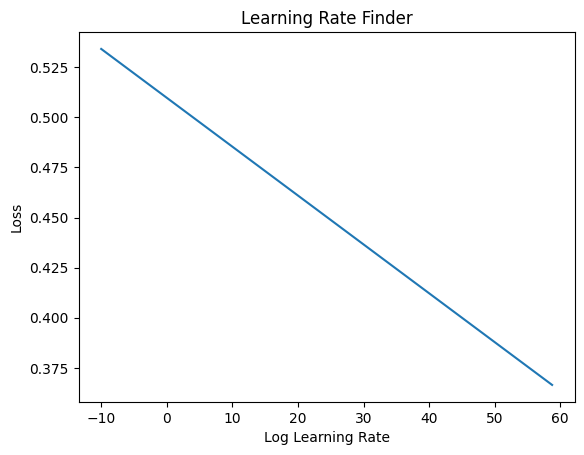

In [26]:
run_test_harness(epochs=40)